In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


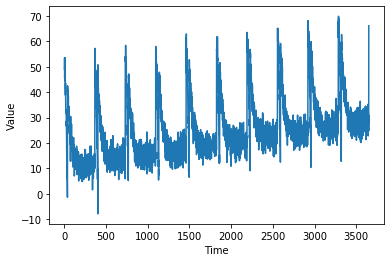

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]



plot_series(time, series)

In [3]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
len(x_train)

3000

In [5]:
x_dataset = tf.data.Dataset.from_tensor_slices(x_train)
x_dataset = x_dataset.window(window_size+1, shift=1, drop_remainder=True)
x_dataset = x_dataset.flat_map(lambda x:x.batch(window_size+1))
x_dataset = x_dataset.map(lambda x:(x[:-1],x[-1:]))
x_dataset = x_dataset.shuffle(shuffle_buffer_size)
x_dataset = x_dataset.batch(batch_size).prefetch(1)

In [6]:
def to_dataset(a):
    x_dataset = tf.data.Dataset.from_tensor_slices(a)
    x_dataset = x_dataset.window(window_size+1, shift=1, drop_remainder=True)
    x_dataset = x_dataset.flat_map(lambda x:x.batch(window_size+1))
    x_dataset = x_dataset.map(lambda x:(x[:-1],x[-1:]))
    x_dataset = x_dataset.shuffle(shuffle_buffer_size)
    x_dataset = x_dataset.batch(batch_size).prefetch(1)
    return x_dataset

In [7]:
train_dataset = to_dataset(x_train)

In [8]:
valid_dataset = to_dataset(x_valid)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Bidirectional, Lambda
from tensorflow.keras.optimizers import Adam

In [11]:
lrs=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8 * 10.0 ** (epoch//20*1.0))

In [12]:
model = Sequential([
    Lambda(lambda x:tf.expand_dims(x, -1)),
    Bidirectional(LSTM(64, input_length=window_size, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1)
])

In [13]:
model.compile(loss='mse', optimizer=Adam(lr=1e-5), metrics=['mse'])

In [14]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [119]:
history=model.fit(x_dataset, validation_data=valid_dataset, epochs=100, callbacks=[lrs])

Epoch 1/100
94/94 [==============================] - 1s 9ms/step - loss: 662.1749 - mse: 662.1749 - val_loss: 990.1065 - val_mse: 990.1065 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 1s 9ms/step - loss: 662.1478 - mse: 662.1478 - val_loss: 990.0703 - val_mse: 990.0703 - lr: 1.0000e-08
Epoch 3/100
94/94 [==============================] - 1s 9ms/step - loss: 662.1208 - mse: 662.1208 - val_loss: 990.0342 - val_mse: 990.0342 - lr: 1.0000e-08
Epoch 4/100
94/94 [==============================] - 1s 9ms/step - loss: 662.0941 - mse: 662.0941 - val_loss: 989.9979 - val_mse: 989.9979 - lr: 1.0000e-08
Epoch 5/100
94/94 [==============================] - 1s 9ms/step - loss: 662.0671 - mse: 662.0671 - val_loss: 989.9622 - val_mse: 989.9622 - lr: 1.0000e-08
Epoch 6/100
94/94 [==============================] - 1s 9ms/step - loss: 662.0404 - mse: 662.0404 - val_loss: 989.9259 - val_mse: 989.9259 - lr: 1.0000e-08
Epoch 7/100
94/94 [==============================] - 1s 9ms/step

In [120]:
model.compile(loss='mse', optimizer=Adam(lr=1e-5), metrics=['mse'])

In [121]:
history=model.fit(x_dataset, validation_data=valid_dataset, epochs=500)

Epoch 1/500
94/94 [==============================] - 2s 19ms/step - loss: 19.2900 - mse: 19.2900 - val_loss: 20.9168 - val_mse: 20.9168
Epoch 2/500
94/94 [==============================] - 1s 9ms/step - loss: 19.1972 - mse: 19.1972 - val_loss: 21.3958 - val_mse: 21.3958
Epoch 3/500
94/94 [==============================] - 1s 9ms/step - loss: 19.0872 - mse: 19.0872 - val_loss: 20.8559 - val_mse: 20.8559
Epoch 4/500
94/94 [==============================] - 1s 9ms/step - loss: 19.0752 - mse: 19.0752 - val_loss: 21.0669 - val_mse: 21.0669
Epoch 5/500
94/94 [==============================] - 1s 10ms/step - loss: 19.0211 - mse: 19.0211 - val_loss: 20.8555 - val_mse: 20.8555
Epoch 6/500
94/94 [==============================] - 1s 10ms/step - loss: 18.9699 - mse: 18.9699 - val_loss: 20.8182 - val_mse: 20.8182
Epoch 7/500
94/94 [==============================] - 1s 9ms/step - loss: 18.9164 - mse: 18.9164 - val_loss: 20.8011 - val_mse: 20.8011
Epoch 8/500
94/94 [==============================] -

94/94 [==============================] - 1s 9ms/step - loss: 17.9420 - mse: 17.9420 - val_loss: 19.5438 - val_mse: 19.5438
Epoch 122/500
94/94 [==============================] - 1s 9ms/step - loss: 18.0564 - mse: 18.0564 - val_loss: 19.4649 - val_mse: 19.4649
Epoch 123/500
94/94 [==============================] - 1s 9ms/step - loss: 18.0001 - mse: 18.0001 - val_loss: 19.5695 - val_mse: 19.5695
Epoch 124/500
94/94 [==============================] - 1s 9ms/step - loss: 17.9809 - mse: 17.9809 - val_loss: 19.5054 - val_mse: 19.5054
Epoch 125/500
94/94 [==============================] - 1s 10ms/step - loss: 17.9751 - mse: 17.9751 - val_loss: 19.5387 - val_mse: 19.5387
Epoch 126/500
94/94 [==============================] - 1s 10ms/step - loss: 17.9538 - mse: 17.9538 - val_loss: 19.4139 - val_mse: 19.4139
Epoch 127/500
94/94 [==============================] - 1s 10ms/step - loss: 17.9670 - mse: 17.9670 - val_loss: 19.2891 - val_mse: 19.2891
Epoch 128/500
94/94 [==============================]

Epoch 181/500
94/94 [==============================] - 1s 9ms/step - loss: 17.7831 - mse: 17.7831 - val_loss: 19.1385 - val_mse: 19.1385
Epoch 182/500
94/94 [==============================] - 1s 9ms/step - loss: 17.8462 - mse: 17.8462 - val_loss: 19.5400 - val_mse: 19.5400
Epoch 183/500
94/94 [==============================] - 1s 9ms/step - loss: 17.7943 - mse: 17.7943 - val_loss: 19.1368 - val_mse: 19.1368
Epoch 184/500
94/94 [==============================] - 1s 9ms/step - loss: 17.8343 - mse: 17.8343 - val_loss: 19.3912 - val_mse: 19.3912
Epoch 185/500
94/94 [==============================] - 1s 9ms/step - loss: 17.7941 - mse: 17.7941 - val_loss: 19.2310 - val_mse: 19.2310
Epoch 186/500
94/94 [==============================] - 1s 9ms/step - loss: 17.8262 - mse: 17.8262 - val_loss: 19.1375 - val_mse: 19.1375
Epoch 187/500
94/94 [==============================] - 1s 9ms/step - loss: 17.8482 - mse: 17.8482 - val_loss: 19.2742 - val_mse: 19.2742
Epoch 188/500
94/94 [====================

Epoch 241/500
94/94 [==============================] - 1s 9ms/step - loss: 17.7162 - mse: 17.7162 - val_loss: 18.9716 - val_mse: 18.9716
Epoch 242/500
94/94 [==============================] - 1s 9ms/step - loss: 17.7231 - mse: 17.7231 - val_loss: 19.0160 - val_mse: 19.0160
Epoch 243/500
94/94 [==============================] - 1s 9ms/step - loss: 17.6536 - mse: 17.6536 - val_loss: 18.8074 - val_mse: 18.8074
Epoch 244/500
94/94 [==============================] - 1s 9ms/step - loss: 17.7256 - mse: 17.7256 - val_loss: 19.3641 - val_mse: 19.3641
Epoch 245/500
94/94 [==============================] - 1s 9ms/step - loss: 17.7294 - mse: 17.7294 - val_loss: 19.1746 - val_mse: 19.1746
Epoch 246/500
94/94 [==============================] - 1s 10ms/step - loss: 17.6546 - mse: 17.6546 - val_loss: 18.7129 - val_mse: 18.7129
Epoch 247/500
94/94 [==============================] - 1s 10ms/step - loss: 17.7130 - mse: 17.7130 - val_loss: 19.3178 - val_mse: 19.3178
Epoch 248/500
94/94 [==================

Epoch 301/500
94/94 [==============================] - 1s 10ms/step - loss: 17.5462 - mse: 17.5462 - val_loss: 19.1605 - val_mse: 19.1605
Epoch 302/500
94/94 [==============================] - 1s 10ms/step - loss: 17.5297 - mse: 17.5297 - val_loss: 18.8589 - val_mse: 18.8589
Epoch 303/500
94/94 [==============================] - 1s 9ms/step - loss: 17.5594 - mse: 17.5594 - val_loss: 18.9578 - val_mse: 18.9578
Epoch 304/500
94/94 [==============================] - 1s 10ms/step - loss: 17.6408 - mse: 17.6408 - val_loss: 19.3887 - val_mse: 19.3887
Epoch 305/500
94/94 [==============================] - 1s 10ms/step - loss: 17.5000 - mse: 17.5000 - val_loss: 19.1978 - val_mse: 19.1978
Epoch 306/500
94/94 [==============================] - 1s 9ms/step - loss: 17.5224 - mse: 17.5224 - val_loss: 18.9089 - val_mse: 18.9089
Epoch 307/500
94/94 [==============================] - 1s 9ms/step - loss: 17.6092 - mse: 17.6092 - val_loss: 19.3842 - val_mse: 19.3842
Epoch 308/500
94/94 [================

Epoch 361/500
94/94 [==============================] - 1s 9ms/step - loss: 17.4067 - mse: 17.4067 - val_loss: 19.5870 - val_mse: 19.5870
Epoch 362/500
94/94 [==============================] - 1s 9ms/step - loss: 17.3099 - mse: 17.3099 - val_loss: 18.5784 - val_mse: 18.5784
Epoch 363/500
94/94 [==============================] - 1s 10ms/step - loss: 17.4091 - mse: 17.4091 - val_loss: 18.8623 - val_mse: 18.8623
Epoch 364/500
94/94 [==============================] - 1s 9ms/step - loss: 17.3712 - mse: 17.3712 - val_loss: 19.1316 - val_mse: 19.1316
Epoch 365/500
94/94 [==============================] - 1s 10ms/step - loss: 17.4039 - mse: 17.4039 - val_loss: 18.8459 - val_mse: 18.8459
Epoch 366/500
94/94 [==============================] - 1s 10ms/step - loss: 17.4376 - mse: 17.4376 - val_loss: 18.4453 - val_mse: 18.4453
Epoch 367/500
94/94 [==============================] - 1s 10ms/step - loss: 17.4403 - mse: 17.4403 - val_loss: 18.8134 - val_mse: 18.8134
Epoch 368/500
94/94 [================

Epoch 421/500
94/94 [==============================] - 1s 9ms/step - loss: 17.2010 - mse: 17.2010 - val_loss: 19.3656 - val_mse: 19.3656
Epoch 422/500
94/94 [==============================] - 1s 9ms/step - loss: 17.0711 - mse: 17.0711 - val_loss: 18.7083 - val_mse: 18.7083
Epoch 423/500
94/94 [==============================] - 1s 9ms/step - loss: 17.2347 - mse: 17.2347 - val_loss: 19.1819 - val_mse: 19.1819
Epoch 424/500
94/94 [==============================] - 1s 9ms/step - loss: 17.1401 - mse: 17.1401 - val_loss: 18.7537 - val_mse: 18.7537
Epoch 425/500
94/94 [==============================] - 1s 9ms/step - loss: 17.2383 - mse: 17.2383 - val_loss: 19.2810 - val_mse: 19.2810
Epoch 426/500
94/94 [==============================] - 1s 9ms/step - loss: 17.1660 - mse: 17.1660 - val_loss: 19.4870 - val_mse: 19.4870
Epoch 427/500
94/94 [==============================] - 1s 9ms/step - loss: 17.1057 - mse: 17.1057 - val_loss: 18.6496 - val_mse: 18.6496
Epoch 428/500
94/94 [====================

Epoch 481/500
94/94 [==============================] - 1s 9ms/step - loss: 16.8785 - mse: 16.8785 - val_loss: 19.0155 - val_mse: 19.0155
Epoch 482/500
94/94 [==============================] - 1s 9ms/step - loss: 16.8628 - mse: 16.8628 - val_loss: 18.4644 - val_mse: 18.4644
Epoch 483/500
94/94 [==============================] - 1s 9ms/step - loss: 16.9109 - mse: 16.9109 - val_loss: 18.6197 - val_mse: 18.6197
Epoch 484/500
94/94 [==============================] - 1s 9ms/step - loss: 16.8662 - mse: 16.8662 - val_loss: 19.0627 - val_mse: 19.0627
Epoch 485/500
94/94 [==============================] - 1s 9ms/step - loss: 16.9231 - mse: 16.9231 - val_loss: 18.8340 - val_mse: 18.8340
Epoch 486/500
94/94 [==============================] - 1s 9ms/step - loss: 16.8495 - mse: 16.8495 - val_loss: 19.4825 - val_mse: 19.4825
Epoch 487/500
94/94 [==============================] - 1s 9ms/step - loss: 16.8784 - mse: 16.8784 - val_loss: 18.9810 - val_mse: 18.9810
Epoch 488/500
94/94 [====================